# MLP from scratch

In this homework, you will code a [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) with one hidden layer to classify text data.

Advice:
- As much as possible, please try to make matrix and vector operations (good practice for efficient code)
- If you're not familiar with numpy, check the documentation of `np.max`, `np.clip`, `np.random.randn`, `np.reshape`. FYI the matrix multiplication operator is `@`, and you may want to learn about [broadcasting rules](https://numpy.org/doc/stable/user/basics.broadcasting.html) to see how it deals with tensor operations of different sizes
- You can also check about `torch.clamp`, `torch.nn.Parameter`

## 1. Some utilities and dataset for Part 2

In [2]:
import plygdata as pg
import numpy as np
data_array = np.array(pg.generate_data(pg.DatasetType.ClassifySpiralData, 0.0))
X = data_array[:,:-1]
Y = data_array[:,-1]
Y = (Y + 1)/2


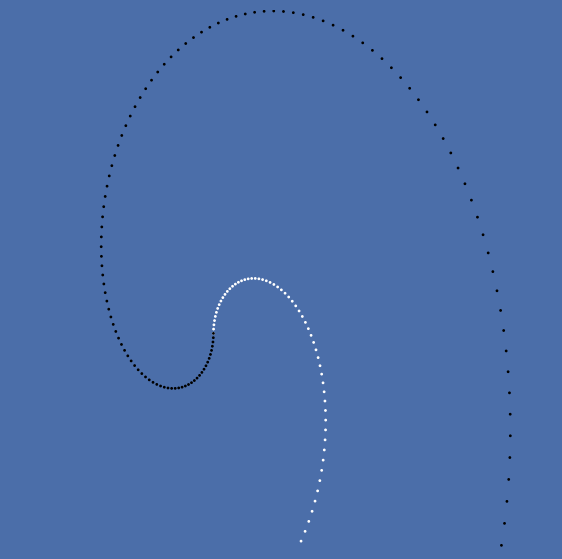

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Plot the dataset
def plot_data(ax, X, Y):
    plt.axis('off')
    ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap='bone')

from sklearn.datasets import make_moons, make_circles, make_classification
# X, Y = make_moons(n_samples=2000, noise=0.1)
#X, Y = make_circles(n_samples=2000, noise=0.0)
#X, Y = make_classification(n_samples=4000, n_features=2, n_informative=2, n_redundant=0, n_repeated=0)
%matplotlib inline
x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
#x_min, x_max = -10, 10
#y_min, y_max = -10, 10
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9', figsize=(7, 7))
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_data(ax, X, Y)
plt.show()

In [4]:
# Define the grid on which we will evaluate our classifier
xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                     np.arange(y_min, y_max, .1))

to_forward = np.array(list(zip(xx.ravel(), yy.ravel())))

# plot the decision boundary of our classifier
def plot_decision_boundary(ax, X, Y, classifier):
    # forward pass on the grid, then convert to numpy for plotting
    #X = X.reshape((-1, 2, 1))
    Z = classifier.forward(to_forward.T)
    Z = Z.reshape(xx.shape)
    
    # plot contour lines of the values of our classifier on the grid
    ax.contourf(xx, yy, Z>0.5, cmap='Blues')
    
    # then plot the dataset
    plot_data(ax, X,Y)

## 2. MLP in numpy

Here you need to code your implementation of the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation and the [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function).

In [5]:
class MyReLU(object):
    def forward(self, x):
        self.out = np.maximum(x, 0)
        return self.out
        
    def backward(self, grad_output):
        return np.where(self.out > 0, grad_output, 0)
    
    def step(self, learning_rate):
        pass

class MySigmoid(object):
    def forward(self, x):
        self.out = np.reciprocal(1 + np.exp(-x))
        return self.out
    
    def backward(self, grad_output):
        return grad_output * self.out * (1 - self.out)
    
    def step(self, learning_rate):
        pass

Probably a good time to test your functions...

In [6]:
test_relu = MyReLU()
test_relu.forward([0, -1, 0.5, -0.5, 0.8, 1])

array([0. , 0. , 0.5, 0. , 0.8, 1. ])

In [7]:
test_relu.backward(np.ones(1))

array([0., 0., 1., 0., 1., 1.])

In [8]:
test_sig = MySigmoid()

test_sig.forward(np.ones(1))

array([0.73105858])

In [9]:
test_sig.backward(np.ones(1))

array([0.19661193])

A bit more complicated, you need now to implement your linear layer i.e. multiplication by a matrix W and summing with a bias b.

$$ y_i = \sum_j W_{i,j} x_j + b_i  \\
         d y_i / d W_{i, j} = x_j \\
         d loss / d y_i = grad_output[i] \\
         so \ d loss / d W_{i,j} = x_j *  gradoutput[i]  (by the chain rule) \\
          d loss / d x_j = \sum_i (d loss / d y_i) (d y_i / d x_j) $$

In [10]:
class MyLinear(object):
    def __init__(self, n_input, n_output):
        self.weights = np.random.randn(n_output, n_input)
        self.bias = np.random.randn(n_output, 1)

    def forward(self, x):
        self.input = x
        return self.weights @ x + self.bias
    
    def backward(self, grad_output):
        self.grad_weights = grad_output @ self.input.T
        self.grad_bias = np.sum(grad_output, axis=1, keepdims=True)

        grad_input = self.weights.T @ grad_output
        return grad_input
    
    def step(self, learning_rate):
        self.weights -= learning_rate * self.grad_weights
        self.bias -= learning_rate * self.grad_bias

Code your network. Note that with a Sigmoid layer, you should use the Binary Cross Entropy (BCE) loss.

In [11]:
class Sequential(object):
    def __init__(self):
        self.layers = [
            MyLinear(2, 10),
            MyReLU(),
            MyLinear(10, 10),
            MyReLU(),
            MyLinear(10, 10),
            MyReLU(),
            MyLinear(10, 10),
            MyReLU(),
            MyLinear(10, 1),
            MySigmoid()
        ]
        
    def forward(self, x):
        cur_out = x
        for layer in self.layers:
            cur_out = layer.forward(cur_out)
        return cur_out
        
    def compute_loss(self, out, label):
        if out == 0:
            out = 1e-10
        elif out == 1:
            out = out - 1e-10
        loss = -(label * np.log(out) + (1-label) * np.log(1-out))
        self.grad_output = (out - label)/(out*(1 - out))
        return loss

    def backward(self):
        cur_grad = self.grad_output
        for layer in reversed(self.layers):
            cur_grad = layer.backward(cur_grad)
    
    def step(self, learning_rate):
        for layer in self.layers:
            layer.step(learning_rate)

In [12]:
model = Sequential()

In [13]:
losses = []
learning_rate = 1e-2
epochs = 10
for epoch in range(epochs):
    loss_sum = 0 
    for it in range(len(X)):
        idx = np.random.randint(0, len(X))
        x = X[idx]
        x = x.reshape(2, 1)
        label = Y[idx]
        out = model.forward(x)
        loss_sum += model.compute_loss(out, label)
        model.backward()
        model.step(learning_rate)
    losses.append(loss_sum)


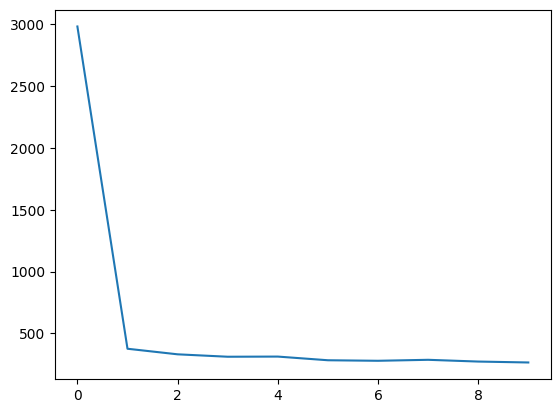

In [14]:
losses = np.array(losses)
losses = losses.reshape((-1, 1))
%matplotlib inline
plt.plot(losses)
plt.show()

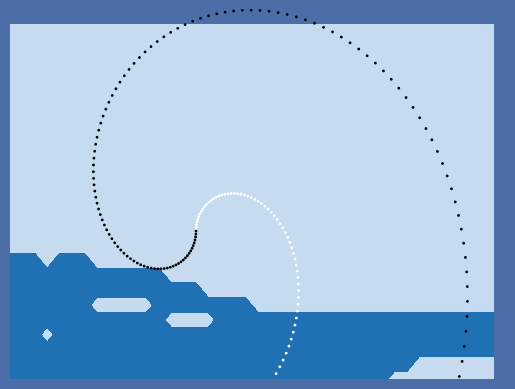

In [15]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_decision_boundary(ax, X, Y, model)
fig.canvas.draw()

## 3. Using a Pytorch module

In this last part, use `toch.nn.Module` to recode `MyLinear` and `MyReLU` so that these modules will be pytorch compatible.

## 3.1. Load & Preprocess the IMDB Dataset

In this section, you are required to read and load the provided `csv` file, and perform the preprocessing steps as specified in the assignment's description.

In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv("assets/data/imdb_dataset.csv")

In [3]:
data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data["sentiment"] = le.fit_transform(data["sentiment"])

In [7]:
data["sentiment"]

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int32

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['review'], data['sentiment'], test_size=0.2)

In [9]:
positive_train_reviews = np.array(X_train[y_train == 1])
negative_train_reviews = np.array(X_train[y_train == 0])
print("positive review:")
print(positive_train_reviews[np.random.randint(0, len(positive_train_reviews))])
print("negative review:")
print(negative_train_reviews[np.random.randint(0, len(negative_train_reviews))])

positive review:
After "Attack of the Fifty Foot Woman" with Alison Hayes opened the doors for women to be just as dangerous as men, there was obviously an open market for other movies to pick up and carry the torch and what more a lovely actress than Dorothy Provine from "It's A Mad, Mad, Mad, Mad World" to play the role. The downsize is that cute and blonde Provine may just be too sweet and innocent looking to step into Allison Hayes' size 50 shoes. This role really needed someone with an amount of smoldering sex appeal; Provine is more the girl next door type. She may have taken and done this role to prove she could be sexy, but the material lets her down. Lou Costello, however, proves he can do a movie without Bud Abbott feeding him lines and he even interjects a dramatic role in some of his scenes when he not turning to Gale Gordon as his front man for gags. Gordon, however, establishes that all he can be is blustery, perturbed and pushy, much the same character he creates later o

In [10]:
positive_train_reviews = np.array(X_test[y_test == 1])
negative_train_reviews = np.array(X_test[y_test == 0])
print("positive review:")
print(positive_train_reviews[np.random.randint(0, len(positive_train_reviews))])
print("negative review:")
print(negative_train_reviews[np.random.randint(0, len(negative_train_reviews))])

positive review:
This is an interesting, hard to find movie from the early 70's starring Jan Michael Vincent as a young man who doesn't make the cut as a marine. Dressed in 'baby blue' outfits to humiliate them as they are sent home, the failed recruits are sent packing. Vincent stops at a bar and runs into a very young Richard Gere who has just returned from a tour in the Pacific as a hard-core Marine 'Raider'. Gere's character is already jaded and contemplating desertion, and he takes advantage of Vincent's innocence, stealing his 'baby blue' uniform after getting him drunk and beating him in an alleyway. Vincent's character, whose name is Marion, takes Gere's outfit and is suddenly transformed into a Marine 'Raider'. Marion hitch-hikes his way into Wyoming and stops at a little Norman Rockwell-like little town. In the local café he meets Rose Hudkins, who immediately catches his eye. Staying with Hudkins parents, Marion attracts all sorts of attention from the towns folks. Mr Hudkin

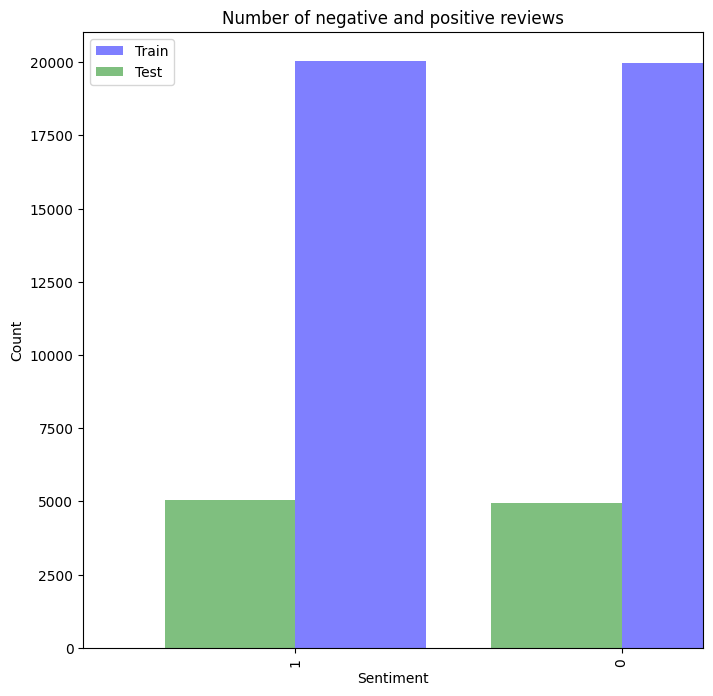

In [11]:
import matplotlib.pyplot as plt
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()
fig, ax = plt.subplots()
train_counts.plot.bar(ax=ax, color='blue', alpha=0.5, width=0.4, position=0, label='Train', figsize=(8, 8))
test_counts.plot.bar(ax=ax, color='green', alpha=0.5, width=0.4, position=1, label='Test')
ax.set_title('Number of negative and positive reviews')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
ax.legend()
plt.show()

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords

# Download stopwords list
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english')) 

# Interface lemma tokenizer from nltk with sklearn
class LemmaTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`']
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in self.ignore_tokens]

# Lemmatize the stop words
tokenizer=LemmaTokenizer()
token_stop = tokenizer(' '.join(stop_words))

# Create TF-idf model
vectorizer = TfidfVectorizer(max_features=3000,stop_words=token_stop, 
                              tokenizer=tokenizer)
vectorizer.fit(X_train.values)
X_train_vec = vectorizer.transform(X_train.values)
X_test_vec = vectorizer.transform(X_test.values)
#features = vectorizer.fit_transform(data["review"])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shahriar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shahriar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\Shahriar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [13]:
(X_train_vec.min() >= 0 and X_train_vec.max() <= 1) and (X_test_vec.min() >= 0 and X_test_vec.max() <= 1)

True

In [14]:
from tensorflow import keras
from keras import models, layers, optimizers

model = models.Sequential()
NEURONS = 128
model.add(layers.Dense(NEURONS, activation='relu', input_shape=(3000,)))
model.add(layers.Dense(NEURONS, activation='relu'))
model.add(layers.Dense(NEURONS, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

optimizer = optimizers.SGD(lr=0.1)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


c:\Users\Shahriar\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
history = model.fit(X_train_vec.toarray(), y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(X_test_vec.toarray(), y_test))

Epoch 1/20
313/313 [==============================] - 3s 9ms/step - loss: 0.6877 - accuracy: 0.5763 - val_loss: 0.6728 - val_accuracy: 0.7244
Epoch 2/20
313/313 [==============================] - 2s 8ms/step - loss: 0.5910 - accuracy: 0.7336 - val_loss: 0.5602 - val_accuracy: 0.6839
Epoch 3/20
313/313 [==============================] - 3s 9ms/step - loss: 0.4551 - accuracy: 0.7793 - val_loss: 0.5370 - val_accuracy: 0.7257
Epoch 4/20
313/313 [==============================] - 2s 8ms/step - loss: 0.3806 - accuracy: 0.8277 - val_loss: 0.3470 - val_accuracy: 0.8511
Epoch 5/20
313/313 [==============================] - 2s 7ms/step - loss: 0.3402 - accuracy: 0.8517 - val_loss: 0.3327 - val_accuracy: 0.8565
Epoch 6/20
313/313 [==============================] - 3s 8ms/step - loss: 0.3092 - accuracy: 0.8688 - val_loss: 0.4180 - val_accuracy: 0.8135
Epoch 7/20
313/313 [==============================] - 3s 8ms/step - loss: 0.2985 - accuracy: 0.8721 - val_loss: 0.3476 - val_accuracy: 0.8516
Epoch 

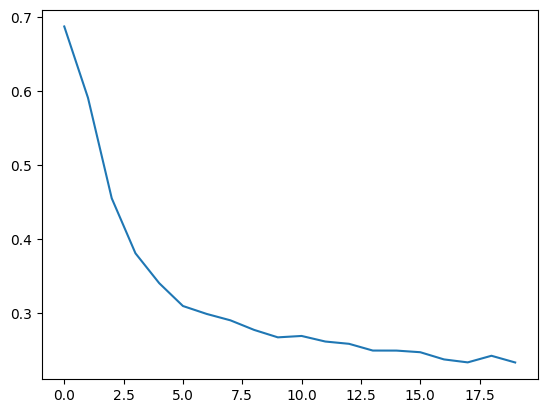

In [16]:
plt.plot(history.history["loss"])

## 3.2. MLP in torch

In [17]:
import torch
import torch.nn as nn
import math

class MyLinear_mod(nn.Module):
    def __init__(self, n_input, n_output):
        super(MyLinear_mod, self).__init__()
        self.weights = nn.Parameter(torch.empty((n_output, n_input)))
        self.bias = nn.Parameter(torch.empty(n_output))
        nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5))
        #nn.init.normal_(self.weights)
        bound = 1 / math.sqrt(n_input)
        nn.init.uniform_(self.bias, -bound, bound)
        #nn.init.normal_(self.bias)



    def forward(self, x):
        return x.matmul(self.weights.t()) + self.bias
        #return torch.nn.functional.linear(x, self.weights, self.bias)
        
class MyReLU_mod(nn.Module):
    def __init__(self):
        super(MyReLU_mod, self).__init__()
        
    def forward(self, x):
        return torch.max(x, torch.tensor(0.))

Define your network using `MyLinear_mod`, `MyReLU_mod` and [`nn.Sigmoid`](https://pytorch.org/docs/stable/nn.html#sigmoid)

In [18]:
X_train_vec.shape

(40000, 3000)

In [19]:
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

In [20]:
X_train_tensor = torch.tensor(X_train_vec.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_vec.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32).view(-1, 1)

In [21]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
NEURONS = 128
# model = nn.Sequential(
#     MyLinear_mod(3000,NEURONS),
#     MyReLU_mod(),
#     MyLinear_mod(NEURONS, NEURONS),
#     MyReLU_mod(),
#     MyLinear_mod(NEURONS, NEURONS),
#     MyReLU_mod(),
#     MyLinear_mod(NEURONS, 1),
#     nn.Sigmoid()
# )
# model = nn.Sequential(
#     MyLinear_mod(3000,NEURONS),
#     nn.ReLU(),
#     MyLinear_mod(NEURONS, NEURONS),
#     nn.ReLU(),
#     MyLinear_mod(NEURONS, NEURONS),
#     nn.ReLU(),
#     MyLinear_mod(NEURONS, 1),
#     nn.Sigmoid()
# )

model = nn.Sequential(
    nn.Linear(3000,NEURONS),
    nn.ReLU(),
    nn.Linear(NEURONS, NEURONS),
    nn.ReLU(),
    nn.Linear(NEURONS, NEURONS),
    nn.ReLU(),
    nn.Linear(NEURONS, 1),
    nn.Sigmoid()
)

In [23]:
from torch import optim
from tqdm import tqdm


optimizer = optim.SGD(model.parameters(), lr=0.1)
#optimizer = optim.RMSprop(model.parameters(), lr=0.001)

losses = []
criterion = nn.BCELoss()
epochs = 20
for epoch in range(epochs):
    model.train()
    
    train_num_correct = 0
    train_num_samples = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    loss_sum = 0
    for batch_idx, (features, labels) in enumerate(pbar):
        optimizer.zero_grad()

        out = model(features)
        loss = criterion(out, labels)
        #print(labels.shape)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        binary_preds = (out > 0.5).float()
        train_num_correct += (binary_preds.int() == labels.int()).sum().item()
        train_num_samples += labels.size(0)
        accuracy = train_num_correct / train_num_samples
        pbar.set_postfix({'Loss': loss.item(), 'Accuracy': f'{accuracy:.2f}%'})
    losses.append(loss_sum / train_num_samples)

    #print(f"train: {train_num_correct / train_num_samples}")
    model.eval()
    
    test_num_correct = 0
    test_num_samples = 0

    # evaluate model on test dataset
    with torch.no_grad():
        for inputs, targets in test_loader:
            # compute outputs
            outputs = model(inputs)
            
            # calculate test accuracy
            binary_preds = (outputs > 0.5).float()
            #print(targets.shape)
            targets = targets.reshape((-1, 1))
            test_num_correct += (binary_preds == targets).sum().item()
            test_num_samples += targets.size(0)
        print(f"test: {test_num_correct / test_num_samples}")
        

Epoch 1: 100%|██████████| 313/313 [00:03<00:00, 94.07it/s, Loss=0.694, Accuracy=0.50%] 


test: 0.5607


Epoch 2: 100%|██████████| 313/313 [00:03<00:00, 95.17it/s, Loss=0.692, Accuracy=0.51%] 


test: 0.4962


Epoch 3: 100%|██████████| 313/313 [00:03<00:00, 96.59it/s, Loss=0.696, Accuracy=0.51%] 


test: 0.5038


Epoch 4: 100%|██████████| 313/313 [00:03<00:00, 97.92it/s, Loss=0.692, Accuracy=0.53%] 


test: 0.4962


Epoch 5: 100%|██████████| 313/313 [00:03<00:00, 95.80it/s, Loss=0.688, Accuracy=0.56%] 


test: 0.595


Epoch 6: 100%|██████████| 313/313 [00:03<00:00, 99.68it/s, Loss=0.668, Accuracy=0.67%] 


test: 0.6502


Epoch 7: 100%|██████████| 313/313 [00:03<00:00, 99.15it/s, Loss=0.758, Accuracy=0.75%] 


test: 0.5787


Epoch 8: 100%|██████████| 313/313 [00:03<00:00, 97.82it/s, Loss=0.488, Accuracy=0.78%] 


test: 0.683


Epoch 9: 100%|██████████| 313/313 [00:03<00:00, 95.41it/s, Loss=0.366, Accuracy=0.83%] 


test: 0.8483


Epoch 10: 100%|██████████| 313/313 [00:03<00:00, 97.26it/s, Loss=0.368, Accuracy=0.85%] 


test: 0.8542


Epoch 11: 100%|██████████| 313/313 [00:03<00:00, 99.11it/s, Loss=0.295, Accuracy=0.86%] 


test: 0.8766


Epoch 12: 100%|██████████| 313/313 [00:03<00:00, 99.59it/s, Loss=0.277, Accuracy=0.87%] 


test: 0.8776


Epoch 13: 100%|██████████| 313/313 [00:03<00:00, 99.43it/s, Loss=0.385, Accuracy=0.88%] 


test: 0.7726


Epoch 14: 100%|██████████| 313/313 [00:03<00:00, 96.64it/s, Loss=0.178, Accuracy=0.88%] 


test: 0.8778


Epoch 15: 100%|██████████| 313/313 [00:03<00:00, 96.01it/s, Loss=0.231, Accuracy=0.89%] 


test: 0.8373


Epoch 16: 100%|██████████| 313/313 [00:03<00:00, 96.83it/s, Loss=0.214, Accuracy=0.89%] 


test: 0.8501


Epoch 17: 100%|██████████| 313/313 [00:03<00:00, 97.13it/s, Loss=0.417, Accuracy=0.89%] 


test: 0.7561


Epoch 18: 100%|██████████| 313/313 [00:03<00:00, 98.86it/s, Loss=0.354, Accuracy=0.89%] 


test: 0.8335


Epoch 19: 100%|██████████| 313/313 [00:03<00:00, 97.31it/s, Loss=0.208, Accuracy=0.90%] 


test: 0.8821


Epoch 20: 100%|██████████| 313/313 [00:03<00:00, 94.16it/s, Loss=0.272, Accuracy=0.89%] 


test: 0.8626


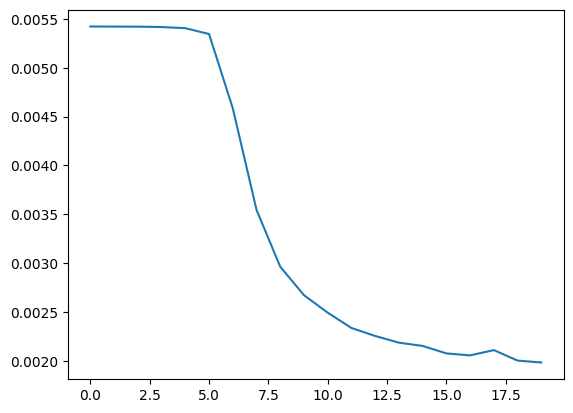

In [24]:
plt.plot(losses)